In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

# библиотеки для скачивания файлов с яндекс-диска
import requests
from urllib.parse import urlencode

# библиотеки для игнорирования предупрждений
import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(16,16)}
        )

olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей
* customer_id — позаказный идентификатор пользователя
* customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)
* customer_zip_code_prefix —  почтовый индекс пользователя
* customer_city —  город доставки пользователя
* customer_state —  штат доставки пользователя

olist_orders_dataset.csv —  таблица заказов
* order_id —  уникальный идентификатор заказа (номер чека)
* customer_id —  позаказный идентификатор пользователя
* order_status —  статус заказа
* order_purchase_timestamp —  время создания заказа
* order_approved_at —  время подтверждения оплаты заказа
* order_delivered_carrier_date —  время передачи заказа в логистическую службу
* order_delivered_customer_date —  время доставки заказа
* order_estimated_delivery_date —  обещанная дата доставки

olist_order_items_dataset.csv —  товарные позиции, входящие в заказы
* order_id —  уникальный идентификатор заказа (номер чека)
* order_item_id —  идентификатор товара внутри одного заказа
* product_id —  ид товара (аналог штрихкода)
* seller_id — ид производителя товара
* shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
* price —  цена за единицу товара
* freight_value —  вес товара

Уникальные статусы заказов в таблице olist_orders_dataset:
* created —  создан
* approved —  подтверждён
* invoiced —  выставлен счёт
* processing —  в процессе сборки заказа
* shipped —  отгружен со склада
* delivered —  доставлен пользователю
* unavailable —  недоступен
* canceled —  отменён

In [3]:
# ссылки на исходные данные

customers_path = 'https://disk.yandex.ru/d/FUi5uSd6BfG_ig'
orders_path = 'https://disk.yandex.ru/d/t9Li4JOfgxuUrg'
items_path = 'https://disk.yandex.ru/d/Gbt-yAcQrOe3Pw'

base_path = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

In [4]:
# получение загрузочных ссылок на исходные данные

for paths in [customers_path, orders_path, items_path]:
    final_path = base_path + urlencode(dict(public_key=paths))
    response = requests.get(final_path)
    download_path = response.json()['href']
    
    if paths == customers_path:
        customers_path = download_path
    elif paths == orders_path:
        orders_path = download_path
    else:
        items_path = download_path

In [5]:
# импорт исходных данных с переводом необходимых колонок в формат datetime

df_customers = pd.read_csv(customers_path)

df_orders = pd.read_csv(orders_path, 
                   parse_dates=['order_purchase_timestamp', 
                                'order_approved_at', 
                                'order_delivered_carrier_date', 
                                'order_delivered_customer_date',
                                'order_estimated_delivery_date'])

df_items = pd.read_csv(download_path, 
                   parse_dates=['shipping_limit_date'])


In [6]:
# проверка типов данных исходных dataframe-ов

df_customers.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [7]:
df_customers.head(1)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP


In [8]:
# проверка типов данных исходных dataframe-ов

df_orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [9]:
df_orders.head(1)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18


In [10]:
# проверка типов данных исходных dataframe-ов

df_items.dtypes

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

In [11]:
df_items.head(1)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29


# ЗАДАНИЕ 1

Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

In [12]:
# покупка будет считаться совершённой, если: 
# имеется факт подтверждения оплаты заказа df_orders.order_approved_at
# статус покупки df_orders.order_status не имеет параметр 'canceled'


successful_purchases = df_orders[(df_orders.order_approved_at.notna()) 
                               & (df_orders.order_status != "canceled")]

In [13]:
# замёрджим получившийся df successful_purchases с df_customers по customer_id, добавив колонку customer_unique_id
# пользователи, совершившие покупку только один раз будут встречаться единожды в колонке customer_unique_id

successful_purchases_merge = successful_purchases \
                             .merge(df_customers[['customer_id', 'customer_unique_id']], 
                             on='customer_id')

In [14]:
single_purchase = (successful_purchases_merge \
                   .customer_unique_id.value_counts() == 1).sum()

In [15]:
print(f'Ответ: \
\nКол-во пользователей, которые совершили покупку только один раз = {single_purchase}')

Ответ: 
Кол-во пользователей, которые совершили покупку только один раз = 92621


# ЗAДАНИЕ 2
Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

In [16]:
# найдём временную отметку, пройденную к моменту последних изменений в df

for time in [df_orders.order_purchase_timestamp,
             df_orders.order_approved_at,
             df_orders.order_delivered_carrier_date,
             df_orders.order_delivered_customer_date]:
    x = time.sort_values(ascending=False).max()
    
    print(x)

2018-10-17 17:30:18
2018-09-03 17:40:06
2018-09-11 19:48:28
2018-10-17 13:22:46


In [17]:
# отберём отменённые, недоступные и неоплаченные заказы

not_delivered_orders = df_orders[df_orders.order_status.isin(['canceled', 'unavailable', 'invoiced'])]

In [18]:
# найдём заказы, которые уже должны быть доставлены к данному моменту согласно колонки order_estimated_delivery_date

still_delivering_orders = df_orders[df_orders.order_status.isin(['approved', 'processing', 'shipped', 'created'])] \
    .sort_values('order_approved_at', ascending=False) \
    .query('order_estimated_delivery_date < "2018-10-18"')

In [19]:
# найдём, где в системе наши заказы не зафиксированы

still_delivering_orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                   5
order_delivered_carrier_date      308
order_delivered_customer_date    1415
order_estimated_delivery_date       0
dtype: int64

In [20]:
# кол-во заказов, по которым не был выставлен счёт для оплаты и не имеющих статусов canceled, unavailable, invoiced

not_billed = still_delivering_orders[still_delivering_orders.order_approved_at.isna()]

not_billed.order_status.value_counts().sum()

5

In [21]:
# кол-во заказов, не переданных в доставку и не имеющих статусов canceled, unavailable, invoiced

not_sent_for_delivery = still_delivering_orders[(still_delivering_orders.order_approved_at.notna()) 
                                              & (still_delivering_orders.order_delivered_carrier_date.isna())]

not_sent_for_delivery.order_status.value_counts().sum()

303

In [22]:
# кол-во заказов, не переданных клиенту службой доставки и не имеющих статусов canceled, unavailable, invoiced

not_sent_for_customer = still_delivering_orders[(still_delivering_orders.order_approved_at.notna())
                                              & (still_delivering_orders.order_delivered_carrier_date.notna()) 
                                              & (still_delivering_orders.order_delivered_customer_date.isna())]

not_sent_for_customer.order_status.value_counts().sum()

1107

In [23]:
# сменим статус заказа на более подходящий

not_billed.order_status = np \
    .where((not_billed.order_status != 'born_to_die'),'not_billed', not_billed.order_status)

not_sent_for_delivery.order_status = np \
    .where((not_sent_for_delivery.order_status != 'lana_del_ray'),'not_sent_for_delivery', not_sent_for_delivery.order_status)

not_sent_for_customer.order_status = np \
    .where((not_sent_for_customer.order_status != 'summertime_sadness'),'not_sent_for_customer', not_sent_for_customer.order_status)

In [24]:
# объединим интересующие нас датафреймы

all_cases = pd.concat([not_delivered_orders, not_billed, not_sent_for_delivery, not_sent_for_customer])

In [25]:
# выведем временную колонку в индекс для успешного resample

all_cases.set_index('order_estimated_delivery_date', inplace=True)

In [26]:
# отредактируем данные для построения удобного графика
# средние значения будут считаться для ожидаемой даты доставки товара

cases_per_month = all_cases \
                    .groupby('order_status', as_index=True) \
                    .resample(rule='M') \
                    .agg({'order_id': 'count'}) \
                    .reset_index() \
                    .rename(columns={'order_estimated_delivery_date': 'date', 'order_id': 'sum_orders'})

In [27]:
# отредактируем дату в удобный формат

cases_per_month.date = cases_per_month.date.dt.strftime("%Y-%m")

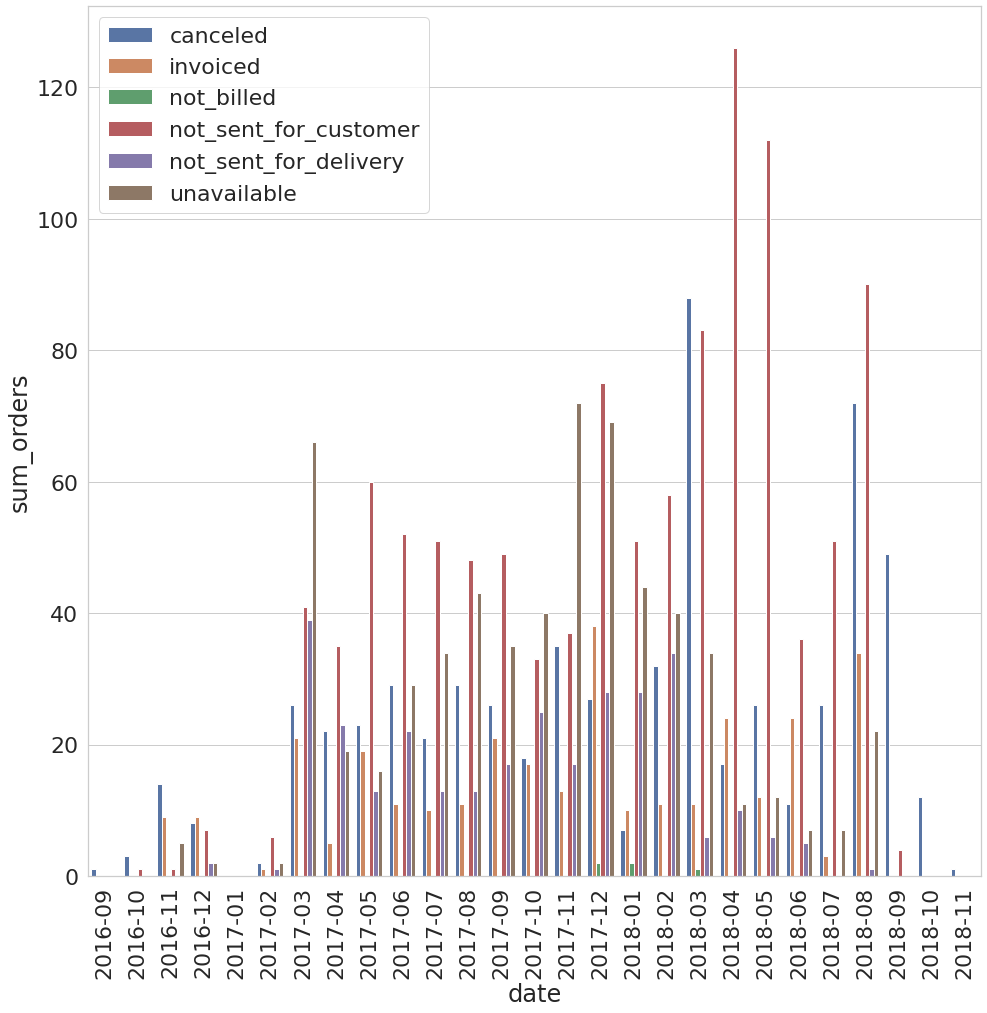

In [28]:
# построим график распределения по месяцам

sns.barplot(data=cases_per_month, x='date', y='sum_orders', hue='order_status')
plt.tick_params(axis='x', rotation=90)
plt.legend(loc='upper left')

In [29]:
# построим сводную ведомость распределения, не доставленных заказов по месяцам

cases_per_month_table = cases_per_month.pivot(index='order_status', columns='date', values='sum_orders').fillna(0)

cases_per_month_table

date,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,...,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11
order_status,,,,,,,,,,,,,,,,,,,,,
canceled,1.0,3.0,14.0,8.0,0.0,2.0,26.0,22.0,23.0,29.0,...,32.0,88.0,17.0,26.0,11.0,26.0,72.0,49.0,12.0,1.0
invoiced,0.0,0.0,9.0,9.0,0.0,1.0,21.0,5.0,19.0,11.0,...,11.0,11.0,24.0,12.0,24.0,3.0,34.0,0.0,0.0,0.0
not_billed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
not_sent_for_customer,0.0,1.0,1.0,7.0,0.0,6.0,41.0,35.0,60.0,52.0,...,58.0,83.0,126.0,112.0,36.0,51.0,90.0,4.0,0.0,0.0
not_sent_for_delivery,0.0,0.0,0.0,2.0,0.0,1.0,39.0,23.0,13.0,22.0,...,34.0,6.0,10.0,6.0,5.0,0.0,1.0,0.0,0.0,0.0
unavailable,0.0,0.0,5.0,2.0,0.0,2.0,66.0,19.0,16.0,29.0,...,40.0,34.0,11.0,12.0,7.0,7.0,22.0,0.0,0.0,0.0


In [30]:
# найдём среднее значение недоставленных товаров в месяц по причинам

status_cases_mean = pd.DataFrame(cases_per_month_table.mean(axis=1)) \
                                                      .reset_index() \
                                                      .rename(columns={0: 'avg_orders'})

status_cases_mean

,order_status,avg_orders
0,canceled,23.148148
1,invoiced,11.629630
2,not_billed,0.185185
3,not_sent_for_customer,41.000000
4,not_sent_for_delivery,11.222222
5,unavailable,22.555556


In [31]:
avg_orders                = status_cases_mean.avg_orders.sum().round(1)
avg_canceled              = status_cases_mean.avg_orders[0].round(1)
avg_invoiced              = status_cases_mean.avg_orders[1].round(1)
avg_not_billed            = status_cases_mean.avg_orders[2].round(1)
avg_not_sent_for_customer = status_cases_mean.avg_orders[3].round(1)
avg_not_sent_for_delivery = status_cases_mean.avg_orders[4].round(1)
avg_unavailable           = status_cases_mean.avg_orders[5].round(1)

In [32]:
print(f'''Ответ: \nВ среднем в месяц не доставляется {avg_orders} заказов. 
\nПричины распределены следующим образом: \
\n{avg_canceled} - по причине отказа, \
\n{avg_invoiced} - отсутствие оплаты, \
\n{avg_not_billed}  - не выставлен счёт для оплаты, \
\n{avg_not_sent_for_delivery} - не переданы в службу доставки, \
\n{avg_not_sent_for_customer} - не переданы клиенту службой доставки, \
\n{avg_unavailable} - недоступны.''')

Ответ: 
В среднем в месяц не доставляется 109.7 заказов. 

Причины распределены следующим образом: 
23.1 - по причине отказа, 
11.6 - отсутствие оплаты, 
0.2  - не выставлен счёт для оплаты, 
11.2 - не переданы в службу доставки, 
41.0 - не переданы клиенту службой доставки, 
22.6 - недоступны.


# ЗАДАНИЕ 3
По каждому товару определить, в какой день недели товар чаще всего покупается.

In [33]:
# используем данные из первого задания, а именно совершённые покупки
# замёрджим получившийся df_items с df successful_purchases по order_id, добавив колонку order_approved_at
# order_approved_at — время подтверждения оплаты заказа

purchased_items = df_items.merge(successful_purchases[['order_id', 'order_approved_at']], on='order_id')

purchased_items.head(1)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_approved_at
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,2017-09-13 09:45:35


In [34]:
# создадим колонку с днём недели оплаты заказа, согласно колонки order_approved_at

purchased_items['weekday'] = purchased_items.order_approved_at.dt.day_name()

purchased_items.head(1)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_approved_at,weekday
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,2017-09-13 09:45:35,Wednesday


In [35]:
# группируем по товарам и дням недели, считая общее кол-во покупок для каждого из товаров в каждый из дней 

weekday_purchases = purchased_items.groupby(['product_id', 'weekday'], as_index=False) \
                                   .agg({'order_id': 'count'}) \
                                   .rename(columns={'order_id': 'orders_sum'})

weekday_purchases.sort_values('orders_sum', ascending=False).head(1)

,product_id,weekday,orders_sum
40854,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,119


In [36]:
# из полученного df находим, какое максимальное кол-во определённого товара в день было куплено

weekday_purchases_max = weekday_purchases.groupby('product_id', as_index=False) \
                                         .agg({'orders_sum': 'max'}) 

weekday_purchases_max.sort_values('orders_sum', ascending=False).head()

,product_id,orders_sum
21961,aca2eb7d00ea1a7b8ebd4e68314663af,119
10789,53b36df67ebb7c41585e8d54d6772e08,105
8555,422879e10f46682990de24d770e7f83d,89
19600,99a4788cb24856965c36a24e339b6058,82
7034,368c6c730842d78016ad823897a372db,80


In [37]:
# мёрджим таблицы, оставляя дни с максимальным значением количества покупок для каждого из товаров

weekday_purchases_all = weekday_purchases_max.merge(weekday_purchases, how='left')

In [38]:
# следим за кол-вом строк

weekday_purchases.shape

(60799, 3)

In [39]:
weekday_purchases_max.shape

(32732, 2)

In [40]:
# и исходя из этого можем сделать вывод, что для определённых товаров существуют разные дни недели,
# в которые совершаются равные максимальные количества покупок

weekday_purchases_all.shape

(42351, 3)

In [41]:
# объединим разные дни с равными максимальными продажами для каждого товара в одну строку

best_weekday_for_product = weekday_purchases_all.groupby(['product_id','orders_sum']) \
                                                .weekday.apply(list) \
                                                .to_frame()

In [42]:
# Ответ:

best_weekday_for_product.sort_values('orders_sum', ascending=False)

,,weekday
product_id,orders_sum,
aca2eb7d00ea1a7b8ebd4e68314663af,119,[Tuesday]
53b36df67ebb7c41585e8d54d6772e08,105,[Tuesday]
422879e10f46682990de24d770e7f83d,89,[Tuesday]
99a4788cb24856965c36a24e339b6058,82,[Tuesday]
368c6c730842d78016ad823897a372db,80,[Thursday]
...,...,...
628d0ba951ebb8fd1edc5ab3934468e0,1,"[Friday, Thursday, Wednesday]"
628cfb8a45c95a7b796ea06b006e9384,1,[Saturday]
628b17449083fb34688b2959b80bdecd,1,"[Friday, Wednesday]"


# ЗАДАНИЕ 4

Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

In [43]:
# также используем данные из первого задания, но на этот раз примем за необходимый для работы df successful_purchases_merge,
# где соблюдены следующие условия:
# имеется факт подтверждения оплаты заказа df_orders.order_approved_at
# статус покупки df_orders.order_status не имеет параметр 'canceled'
# создана колонка с уникальным id клиента

successful_purchases_merge.head(1)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff


In [44]:
# создадим новую колонку, в которой будет содержаться год и месяц оплаты заказа

successful_purchases_merge['year_month'] = pd.to_datetime(successful_purchases_merge.order_approved_at.dt.strftime('%Y-%m'))

successful_purchases_merge.head(1)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,year_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,2017-10-01


In [45]:
# найдём кол-во всех покупок для каждого пользователя по месяцам

purchases_per_week = successful_purchases_merge.groupby(['customer_unique_id', 'year_month'], as_index=False) \
                                                .agg({'order_id': 'count'}) \
                                                .rename(columns={'order_id': 'sum_orders'}) \
                                                .sort_values('sum_orders', ascending=False)

purchases_per_week.head(1)

,customer_unique_id,year_month,sum_orders
7274,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01-01,6


In [46]:
# создадим колонку с кол-вом недель в месяце

purchases_per_week['weeks_in_month'] = purchases_per_week.year_month.dt.days_in_month / 7

purchases_per_week.head(1)

,customer_unique_id,year_month,sum_orders,weeks_in_month
7274,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01-01,6,4.428571


In [47]:
# создадим колонку со средним кол-вом покупок в неделю (по месяцам) для каждого из пользователей

purchases_per_week['purchases_per_week_mean'] = purchases_per_week.sum_orders / purchases_per_week.weeks_in_month

purchases_per_week.year_month = purchases_per_week.year_month.dt.strftime('%Y-%m')

In [48]:
#Ответ:

purchases_per_week.sort_values('purchases_per_week_mean', ascending=False)

,customer_unique_id,year_month,sum_orders,weeks_in_month,purchases_per_week_mean
7274,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01,6,4.428571,1.354839
61809,a239b8e2fbce33780f1f1912e2ee5275,2017-02,4,4.000000,1.000000
23794,3e43e6105506432c953e165fb2acf44c,2018-02,4,4.000000,1.000000
68959,b4e4f24de1e8725b74e4a1f4975116ed,2018-02,4,4.000000,1.000000
14391,25a560b9a6006157838aab1bdbd68624,2017-04,4,4.285714,0.933333
...,...,...,...,...,...
73548,c0db9d178b216ab153fcf56d6382f735,2017-08,1,4.428571,0.225806
73557,c0e0c6e5b85080dbdf3f021b55edbb3e,2017-03,1,4.428571,0.225806
73556,c0e0c0faeae91a736ee4c33bb0a24e16,2017-10,1,4.428571,0.225806
73555,c0e0099353963aa2d4aeb0f79b564e1f,2017-10,1,4.428571,0.225806


# ЗАДАНИЕ 5
Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

In [49]:
# воспользуемся df successful_purchases_merge из прошлого задания
# в колонке year_month указан месяц, в который была совершена покупка

prep_cohorts = successful_purchases_merge.copy()
prep_cohorts = successful_purchases_merge[['customer_unique_id', 'order_id',
                                         'order_approved_at', 'year_month']] \
                                         .rename(columns={'year_month': 'month_of_purchase'})

prep_cohorts.head(1)

,customer_unique_id,order_id,order_approved_at,month_of_purchase
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 11:07:15,2017-10-01


In [50]:
# создадим колонку с месяцем первой покупки для уникального юзера

prep_cohorts['first_month_of_purchase_for_user'] = prep_cohorts \
                        .groupby('customer_unique_id')['month_of_purchase'].transform(min)

prep_cohorts.head(1)

,customer_unique_id,order_id,order_approved_at,month_of_purchase,first_month_of_purchase_for_user
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 11:07:15,2017-10-01,2017-09-01


In [51]:
# создаем колонку с числом месяцев, прошедших с момента первой покупки юзером

prep_cohorts['from_first_purchase_M'] = ((prep_cohorts.month_of_purchase - prep_cohorts.first_month_of_purchase_for_user) /
                                          np.timedelta64(1, 'M')) \
                                          .round() \
                                          .astype('int')

# убеждаемся, что всё посчитано верно

prep_cohorts.query('month_of_purchase != first_month_of_purchase_for_user') \
                   .sort_values('from_first_purchase_M', ascending = False).head()

,customer_unique_id,order_id,order_approved_at,month_of_purchase,first_month_of_purchase_for_user,from_first_purchase_M
15,ccafc1c3f270410521c3c6f3b249870f,dcb36b511fcac050b97cd5c05de84dc3,2018-06-12 23:31:02,2018-06-01,2016-10-01,20
68862,32ea3bdedab835c3aa6cb68ce66565ef,ebf144597fc5b016fb405d0fea5c9e2d,2018-06-28 12:40:56,2018-06-01,2016-10-01,20
41014,d8f3c4f441a9b59a29f977df16724f38,b2947cf9a8d3084369dfcbe9663dd545,2018-08-25 04:05:18,2018-08-01,2017-01-01,19
72972,87b3f231705783eb2217e25851c0a45d,6d86a700fbdfec909998eefa9110f3e9,2018-05-04 11:51:35,2018-05-01,2016-10-01,19
66796,94e5ea5a8c1bf546db2739673060c43f,2f53e1db0b2a17564ef12fe69d65a9df,2018-05-09 14:14:57,2018-05-01,2016-10-01,19


In [52]:
# переведём время в более удобный формат

prep_cohorts['month_of_purchase'] = prep_cohorts.month_of_purchase.dt.strftime('%Y-%m')
prep_cohorts['first_month_of_purchase_for_user'] = prep_cohorts.first_month_of_purchase_for_user.dt.strftime('%Y-%m')

In [53]:
# строим когорту

cohorts = prep_cohorts.pivot_table(index='first_month_of_purchase_for_user', columns='from_first_purchase_M', 
                                   values='customer_unique_id', aggfunc='count')
cohorts

from_first_purchase_M,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
first_month_of_purchase_for_user,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,300.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,2.0,2.0
2016-12,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,757.0,4.0,2.0,1.0,3.0,1.0,4.0,1.0,1.0,NaN,2.0,2.0,6.0,3.0,1.0,1.0,2.0,3.0,1.0,NaN
2017-02,1746.0,4.0,4.0,3.0,7.0,2.0,4.0,3.0,2.0,4.0,2.0,5.0,3.0,3.0,2.0,1.0,1.0,5.0,NaN,NaN
2017-03,2652.0,14.0,9.0,11.0,9.0,4.0,4.0,8.0,8.0,3.0,10.0,4.0,6.0,3.0,4.0,6.0,2.0,4.0,NaN,NaN
2017-04,2341.0,15.0,6.0,5.0,6.0,6.0,9.0,6.0,8.0,4.0,5.0,2.0,2.0,1.0,2.0,2.0,5.0,NaN,NaN,NaN
2017-05,3644.0,20.0,21.0,14.0,11.0,15.0,17.0,6.0,9.0,12.0,10.0,12.0,8.0,2.0,8.0,10.0,NaN,NaN,NaN,NaN
2017-06,3193.0,14.0,12.0,13.0,8.0,11.0,11.0,7.0,4.0,7.0,10.0,11.0,5.0,4.0,7.0,NaN,NaN,NaN,NaN,NaN


In [54]:
# Изменим данные, так, чтобы показать доли возврата от первоначального размера когорты.

retention = cohorts.div(cohorts[0], axis=0).mul(100).round(2)
retention

from_first_purchase_M,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
first_month_of_purchase_for_user,,,,,,,,,,,,,,,,,,,,
2016-09,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,100.0,NaN,NaN,NaN,NaN,NaN,0.33,NaN,NaN,0.33,NaN,0.33,NaN,0.33,NaN,0.33,NaN,0.33,0.67,0.67
2016-12,100.0,100.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,100.0,0.53,0.26,0.13,0.40,0.13,0.53,0.13,0.13,NaN,0.26,0.26,0.79,0.40,0.13,0.13,0.26,0.40,0.13,NaN
2017-02,100.0,0.23,0.23,0.17,0.40,0.11,0.23,0.17,0.11,0.23,0.11,0.29,0.17,0.17,0.11,0.06,0.06,0.29,NaN,NaN
2017-03,100.0,0.53,0.34,0.41,0.34,0.15,0.15,0.30,0.30,0.11,0.38,0.15,0.23,0.11,0.15,0.23,0.08,0.15,NaN,NaN
2017-04,100.0,0.64,0.26,0.21,0.26,0.26,0.38,0.26,0.34,0.17,0.21,0.09,0.09,0.04,0.09,0.09,0.21,NaN,NaN,NaN
2017-05,100.0,0.55,0.58,0.38,0.30,0.41,0.47,0.16,0.25,0.33,0.27,0.33,0.22,0.05,0.22,0.27,NaN,NaN,NaN,NaN
2017-06,100.0,0.44,0.38,0.41,0.25,0.34,0.34,0.22,0.13,0.22,0.31,0.34,0.16,0.13,0.22,NaN,NaN,NaN,NaN,NaN


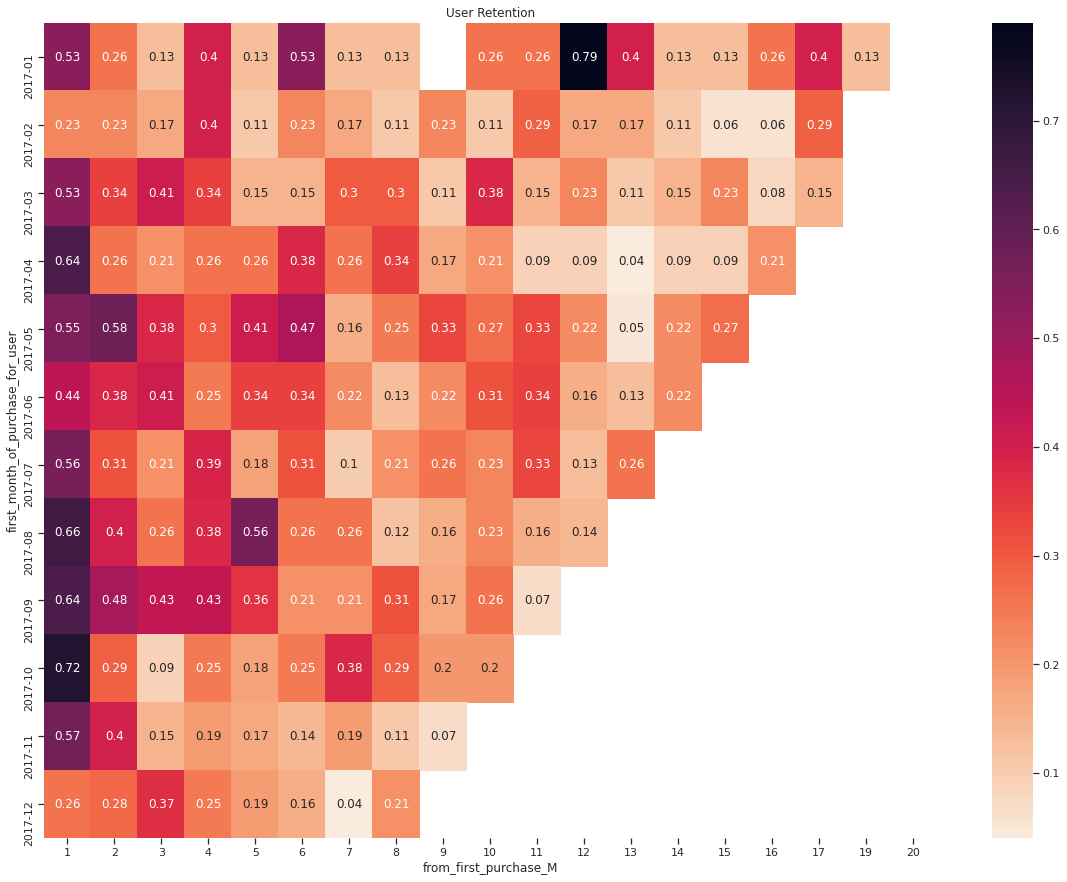

In [55]:
# построим тепловую карту когортного анализа для 2017 года

sns.set(style='ticks')
plt.figure(figsize=(20, 15))
plt.title('User Retention')
ax = sns.heatmap(data=retention.loc['2017-01':'2017-12', 1:], annot=True, cmap="rocket_r")

In [56]:
# Когорта с самым высоким retention на третий месяц

retention[3].idxmax()

'2017-09'

# ЗАДАНИЕ 6

Часто для качественного анализа аудитории используют подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров.

In [57]:
# актуальная дата, согласно колонке successful_purchases_merge.order_approved_at

current_date = successful_purchases_merge.order_approved_at.max() + pd.to_timedelta(1, 'd')

current_date

Timestamp('2018-09-04 17:40:06')

In [58]:
# отберём только необходимые для дальнейшей работы колонки

rfm_df = successful_purchases_merge[['customer_unique_id', 'order_approved_at', 'order_id']] \
                                     .merge(df_items[['order_id', 'price', 'freight_value']], on='order_id', how='inner')

In [59]:
# сумма покупки будет рассчитываться по произведению цены товара на его вес

rfm_df['payment_value'] = rfm_df.price * rfm_df.freight_value.round(2)

rfm_df.head(1)

,customer_unique_id,order_approved_at,order_id,price,freight_value,payment_value
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 11:07:15,e481f51cbdc54678b7cc49136f2d6af7,29.99,8.72,261.5128


In [60]:
# по каждому пользователю посчитаем recency - время от последней покупки пользователя до текущей даты,
# frequency - суммарное количество покупок у пользователя за всё время, monetary_value - сумма покупок за всё время

rfmTable = rfm_df.groupby('customer_unique_id') \
                    .agg({'order_approved_at': lambda x: (current_date - x.max()).days,
                          'order_id': pd.Series.nunique,
                          'payment_value': 'sum'})

rfmTable.rename(columns= {'order_approved_at': 'recency',
                          'order_id': 'frequency',
                          'payment_value': 'monetary_value'}, inplace=True)

Границы метрик
* для recency использовал интервалы *0-30, 30-90, 90-180, 180-360, 360-max*, потому что данные показатели показались мне логичными, по принадлежности юзера к той или иной группе можно сделать одназначные логические выводы (потерян для нас клиент или нет, кто пользовался нашими услугами недавно, кого ещё можно привлечь к пользованию нашими услугами)
* для frequency исползовал граничащие значения равные *1, 2, 3, 4 и остальные*, так как, судя по графику ниже, основная масса клиентов не совершила более одного заказа, любая другая форма деления была бы неиформативной
* для monetary_value значения было решено распределять по квантилям, так как в колонке имеются значения сильно отличающиеся от основной массы

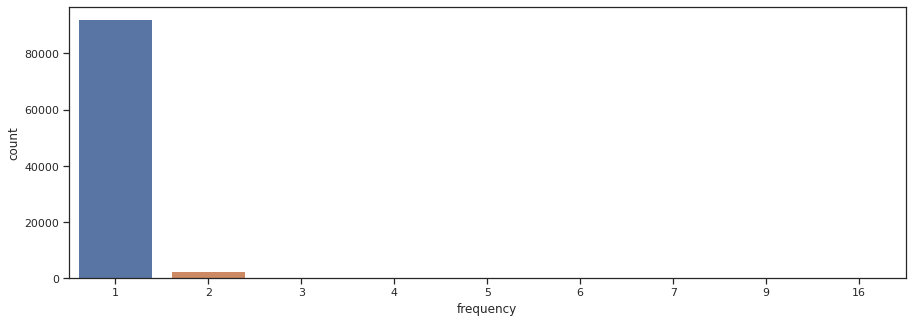

In [61]:
plt.figure(figsize=(15, 5))
sns.countplot(rfmTable.frequency)

In [62]:
rfm = rfmTable.copy()

In [63]:
# создадим словарь, содержащий квантили для интерпретации

quantiles = rfmTable.quantile(q=[.25, .5, .75, .95])
quantiles = quantiles.to_dict()
quantiles

{'recency': {0.25: 119.0, 0.5: 224.0, 0.75: 353.0, 0.95: 525.0},
 'frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 1.0, 0.95: 1.0},
 'monetary_value': {0.25: 652.212,
  0.5: 1435.1,
  0.75: 3199.2365,
  0.95: 13432.72}}

Необходимо написать функции для интерпритации значений. 
Чем больше значение интерпритации, тем важнее для нас клиент.

Для **recency** *наибольшие* значения интерпритации будут принадлжеать тем клиентам, кто сделал последний заказ в прошедших 30 днях, *наименьшие* - тем, кто не заказывал ничего больше года.

Для **frequency** *наибольшие* значения интерпритации будут принадлжеать тем клиентам, кто делал больше всего заказов в течение всего времени, *наименьшие* - тем, кто сделал только 1 заказ.

Для **monetary_value** *наибольшие* значения интерпритации будут принадлежать тем клиентам, кто потратил больше всего денег на покупки в течние всего времени, *наименьшие* - тем, кто тратил меньше всего.

In [64]:
def R_def(R):
    if R > 360 and R <= rfm.recency.max():
        return 1
    elif R > 180 and R <= 360:
        return 2
    elif R > 90 and R <= 180:
        return 3
    elif R > 30 and R <= 90:
        return 4
    else:
        return 5

def F_def(F):
    if F == 1:
        return 1
    elif F == 2:
        return 2
    elif F == 3:
        return 3
    elif F == 4:
        return 4
    else:
        return 5


def MScore(M, key):
    if M <= quantiles[key][.25]:
        return 1
    elif M <= quantiles[key][.5]:
        return 2
    elif M <= quantiles[key][.75]:
        return 3
    elif M <= quantiles[key][.95]:
        return 4
    else:
        return 5

In [65]:
# применяем функции, создаём RFM-сегментацию интерпретируя значения

rfm['R'] = rfm['recency'].apply(R_def)
rfm['F'] = rfm['frequency'].apply(F_def)
rfm['M'] = rfm['monetary_value'].apply(MScore, key='monetary_value')

rfm['RFM'] = rfm.R.map(str) + rfm.F.map(str) + rfm.M.map(str)

In [66]:
# проверяем правильность выполнения скрипта

rfm.sort_values('R', ascending=True).head(1)

,recency,frequency,monetary_value,R,F,M,RFM
customer_unique_id,,,,,,,
ffffd2657e2aad2907e67c3e9daecbeb,489,1,830.3443,1,1,2,112


In [67]:
rfm.sort_values('R', ascending=False).head(1)

,recency,frequency,monetary_value,R,F,M,RFM
customer_unique_id,,,,,,,
495f005aabbf7f43683c66610fdb8c1e,21,1,3956.4,5,1,4,514


In [68]:
rfm.sort_values('F', ascending=True).head(1)

,recency,frequency,monetary_value,R,F,M,RFM
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,117,1,1558.8,3,1,3,313


In [69]:
rfm.sort_values('F', ascending=False).head(1)

,recency,frequency,monetary_value,R,F,M,RFM
customer_unique_id,,,,,,,
47c1a3033b8b77b3ab6e109eb4d5fdf3,222,6,15382.552,2,5,5,255


In [70]:
rfm.sort_values('M', ascending=True).head(1)

,recency,frequency,monetary_value,R,F,M,RFM
customer_unique_id,,,,,,,
7fb6db76737f019f045f48f7b9c9d3c0,315,1,355.3815,2,1,1,211


In [71]:
rfm.sort_values('M', ascending=False).head(1)

,recency,frequency,monetary_value,R,F,M,RFM
customer_unique_id,,,,,,,
59f39bcc60ca8e68cbec962e2afd70f8,234,1,19376.916,2,1,5,215


In [72]:
# распределение наших клиентов согласно RFM-сегментации

RFM_users = rfm.reset_index() \
                         .groupby('RFM', as_index=False) \
                         .agg({'customer_unique_id': 'count'}) \
                         .rename(columns={'customer_unique_id': 'customers'})

RFM_users

,RFM,customers
0,111,5675
1,112,5780
2,113,5422
3,114,4066
4,115,1030
...,...,...
91,535,2
92,544,4
93,545,2
94,554,2


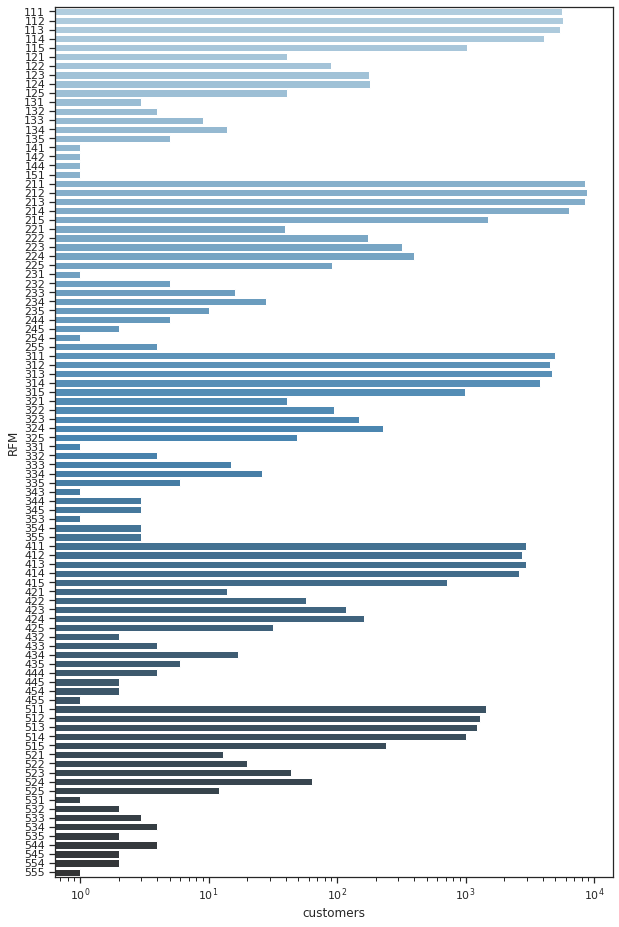

In [73]:
# прологарифмированный график распределения пользователей согласно параметров нашей сегментации юзеров

plt.figure(figsize=(10, 16))
plt.xscale('log')
sns.barplot(data=RFM_users, y='RFM', x='customers', orient='h', palette="Blues_d");